In [3]:
import sys
 
sys.path.insert(0, "../")

from EnsembleFramework import Framework

In [4]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

dataset_name = 'Cora'
split = "public"
dataset = Planetoid(root='/tmp/Cora', name=dataset_name, split=split)
dataset.transform = T.NormalizeFeatures()

features =  dataset[0].x
y =  dataset[0].y

test =  dataset[0].test_mask
train = dataset[0].train_mask
val =  dataset[0].val_mask

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

In [10]:
import pandas as pd
import ast

hops_to_best_params_df = pd.read_csv("normalized_origin_features_plus_summed_neighbors_wo_attn.csv")
evaluated_hops = hops_to_best_params_df.iloc[:,0].values
best_params = hops_to_best_params_df.iloc[:,1].values
hops_to_best_params = dict({hop: ast.literal_eval(best_params[i]) for i, hop in enumerate(evaluated_hops)})
hops_to_best_params

{0: {'C': 3.346048903444868,
  'l1_ratio': 0.01220223988095433,
  'max_iter': 1024,
  'penalty': None,
  'tol': 0.011398278271416415},
 2: {'C': 6.552418536384322,
  'l1_ratio': 0.35616288828645437,
  'max_iter': 512,
  'penalty': 'l2',
  'tol': 0.02129975507663451},
 5: {'C': 3.886954615084303,
  'l1_ratio': 0.3160574463568011,
  'max_iter': 8192,
  'penalty': None,
  'tol': 0.03825901150144381},
 10: {'C': 4.268895952270713,
  'l1_ratio': 0.6429245814995024,
  'max_iter': 512,
  'penalty': None,
  'tol': 0.016167762825700257},
 15: {'C': 0.6168486310332411,
  'l1_ratio': 0.16300287291983964,
  'max_iter': 2048,
  'penalty': None,
  'tol': 0.014971722036123054},
 20: {'C': 6.4371186505294355,
  'l1_ratio': 0.2784660827787615,
  'max_iter': 4096,
  'penalty': None,
  'tol': 0.006976930666800651},
 30: {'C': 4.080036163461636,
  'l1_ratio': 0.16213887591692455,
  'max_iter': 512,
  'penalty': None,
  'tol': 0.002421171636711944},
 1: {'C': 1.2938518450759626,
  'l1_ratio': 0.27222180589

In [5]:
hops_to_best_params = {0: {'C': 3.780072403480011,
  'l1_ratio': 0.8170098572039945,
  'max_iter': 512,
  'penalty': None,
  'tol': 0.01124727090043571},
 1: {'C': 8.194215399517963,
  'l1_ratio': 0.24139147168231181,
  'max_iter': 512,
  'penalty': None,
  'tol': 0.011760502330830296},
 2: {'C': 6.763454003366656,
  'l1_ratio': 0.683211587128955,
  'max_iter': 1024,
  'penalty': 'l2',
  'tol': 0.046731573677952644},
 3: {'C': 5.864476041301294,
  'l1_ratio': 0.07244905164672959,
  'max_iter': 16384,
  'penalty': 'elasticnet',
  'tol': 0.0053169159363401445},
 5: {'C': 7.9167756138312475,
  'l1_ratio': 0.05714673409756832,
  'max_iter': 1024,
  'penalty': 'l2',
  'tol': 0.02508325451476101},
 10: {'C': 1.9577848307489105,
  'l1_ratio': 0.20485601040275186,
  'max_iter': 8192,
  'penalty': None,
  'tol': 0.006507042657483245}}

In [6]:
hops_to_best_params = {0: {'C': 3.346048903444868,
  'l1_ratio': 0.01220223988095433,
  'max_iter': 1024,
  'penalty': None,
  'tol': 0.011398278271416415},
 2: {'C': 6.552418536384322,
  'l1_ratio': 0.35616288828645437,
  'max_iter': 512,
  'penalty': 'l2',
  'tol': 0.02129975507663451},
 5: {'C': 3.886954615084303,
  'l1_ratio': 0.3160574463568011,
  'max_iter': 8192,
  'penalty': None,
  'tol': 0.03825901150144381},
 10: {'C': 4.268895952270713,
  'l1_ratio': 0.6429245814995024,
  'max_iter': 512,
  'penalty': None,
  'tol': 0.016167762825700257},
 15: {'C': 9.334260127671346,
  'l1_ratio': 0.6438450087129208,
  'max_iter': 16384,
  'penalty': None,
  'tol': 0.008342788591252898},
 20: {'C': 1.747367564486253,
  'l1_ratio': 0.14772016160343032,
  'max_iter': 1024,
  'penalty': None,
  'tol': 0.006981350357578392},
 30: {'C': 3.9252161926287337,
  'l1_ratio': 0.0011402047702883302,
  'max_iter': 128,
  'penalty': None,
  'tol': 0.002375637603020751}}

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from torch.nn.functional import normalize

def user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1) #normalize(kwargs["updated_features"] + kwargs["summed_neighbors"], p = 2.0, dim = 1)
    
for hop in [0,2,5,10, 20, 30]:
    hops_list = [0, hop]
    
    clfs = [
        LogisticRegression(**hops_to_best_params[hops], random_state = 42, solver= "saga") for hops in hops_list
    ]
    framework = Framework([user_function for i in hops_list], 
                         hops_list=hops_list, ## to obtain best for local neighborhood
                         clfs=clfs,
                         gpu_idx=0,
                         handle_nan=0.0,
                        attention_configs=[None for i in hops_list])
    start = time.time()
    framework.fit(features,
                edge_index,
                y,
                train)
    train_time = time.time()-start
    
    y_pred_val = framework.predict(features,
                    edge_index,
                    val)
    y_pred_test = framework.predict(features,
                    edge_index,
                    test)
    y_pred_train = framework.predict(features,
                    edge_index,
                    train)
    val_score = accuracy_score(y[val], y_pred_val)
    test_score = accuracy_score(y[test], y_pred_test)
    train_score = accuracy_score(y[train], y_pred_train)
    print(f"Logistic regression with 0 hops (self-awareness) and {str(hop)} hops has the following accuracies:\nTrain acc: {str(train_score)}; Val acc {str(val_score)}; Test acc {str(test_score)}")
    print(f"The required training time was {str(round(train_time,2))} s")

/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 0 hops has the following accuracies:
Train acc: 1.0; Val acc 0.604; Test acc 0.6
The required training time was 0.98 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 2 hops has the following accuracies:
Train acc: 1.0; Val acc 0.776; Test acc 0.803
The required training time was 0.47 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 5 hops has the following accuracies:
Train acc: 1.0; Val acc 0.804; Test acc 0.82
The required training time was 0.51 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 10 hops has the following accuracies:
Train acc: 1.0; Val acc 0.808; Test acc 0.825
The required training time was 0.68 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 20 hops has the following accuracies:
Train acc: 1.0; Val acc 0.8; Test acc 0.822
The required training time was 1.11 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic regression with 0 hops (self-awareness) and 30 hops has the following accuracies:
Train acc: 1.0; Val acc 0.816; Test acc 0.82
The required training time was 1.93 s


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(scores):
    node_labels = y.cpu().numpy()
    num_classes = len(set(node_labels))
    
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(scores)
    
    fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}
    for class_id in range(num_classes):
        
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
    plt.show()

/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [0]


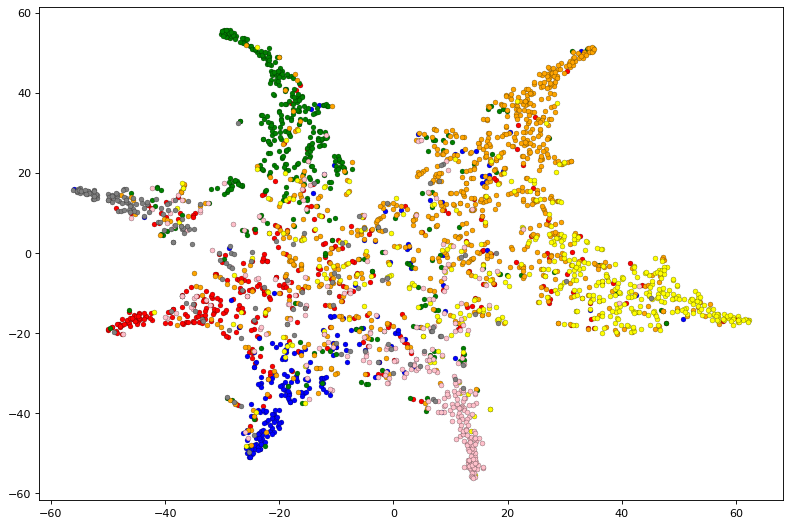

Logistic regression with [0] hops has the following accuracies:
Train acc: 1.0; Val acc 0.604; Test acc 0.6
The required training time was 0.31 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


T-SNE of learned proba with [2]


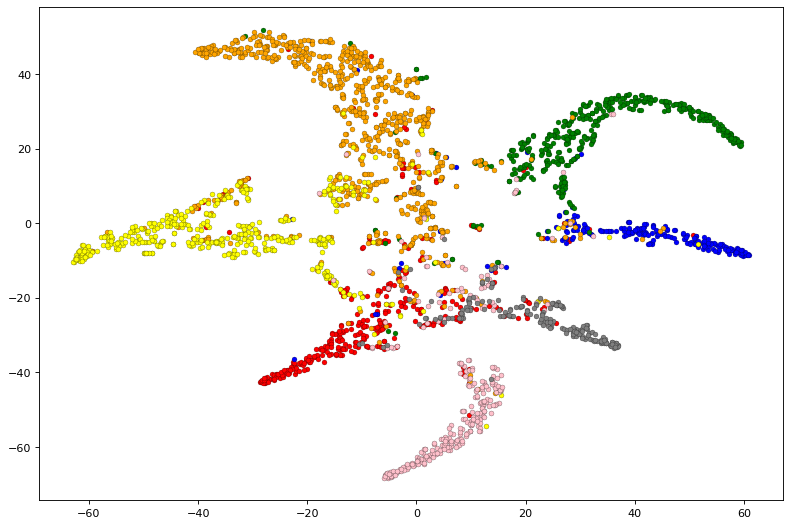

Logistic regression with [2] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.806; Test acc 0.819
The required training time was 0.12 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [5]


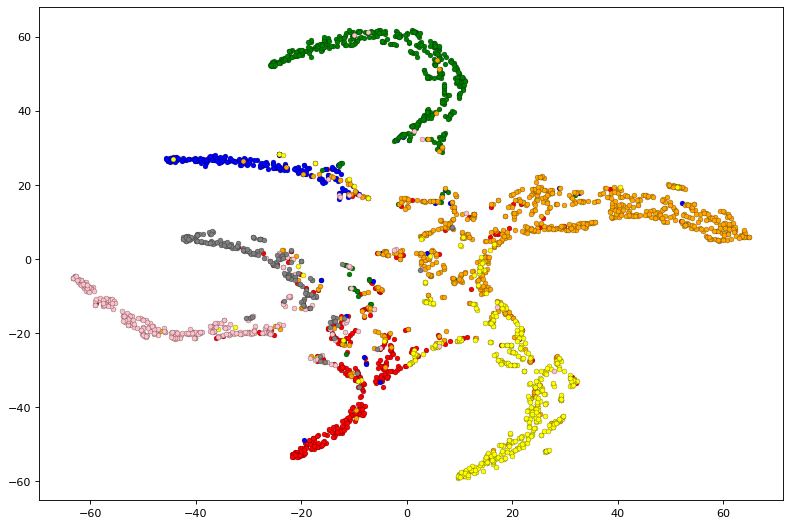

Logistic regression with [5] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.816; Test acc 0.822
The required training time was 0.2 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [10]


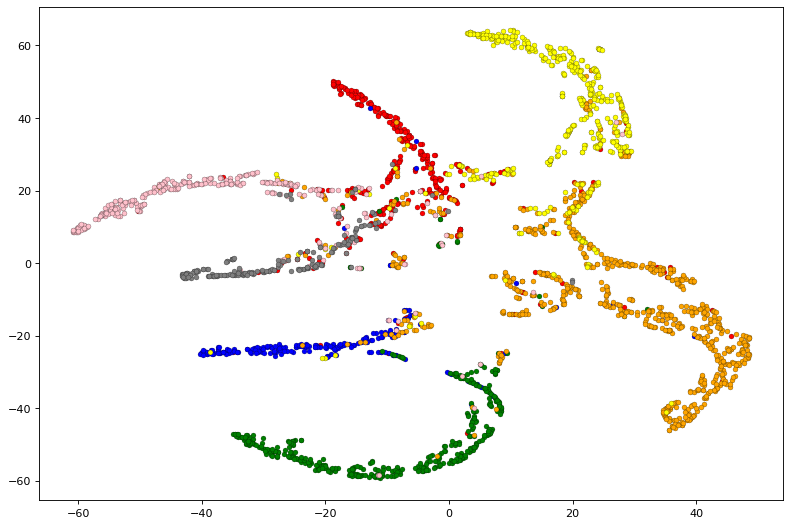

Logistic regression with [10] hops has the following accuracies:
Train acc: 0.9857142857142858; Val acc 0.816; Test acc 0.813
The required training time was 0.37 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [15]


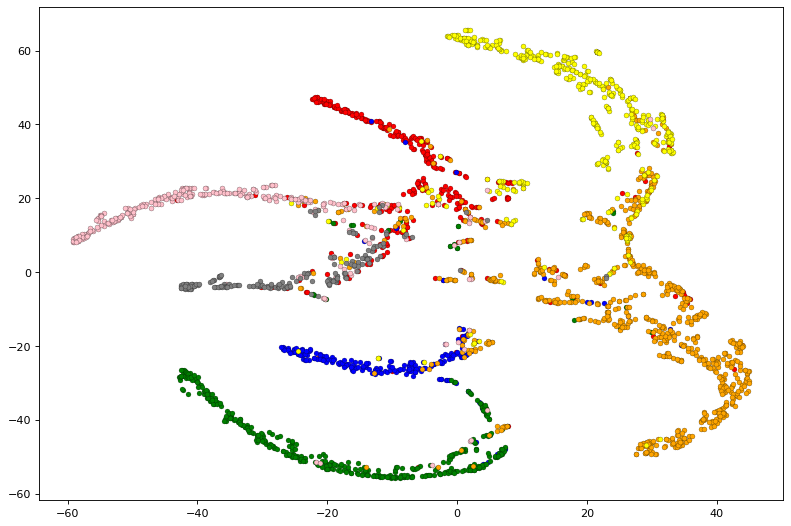

Logistic regression with [15] hops has the following accuracies:
Train acc: 0.9857142857142858; Val acc 0.822; Test acc 0.807
The required training time was 0.52 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [20]


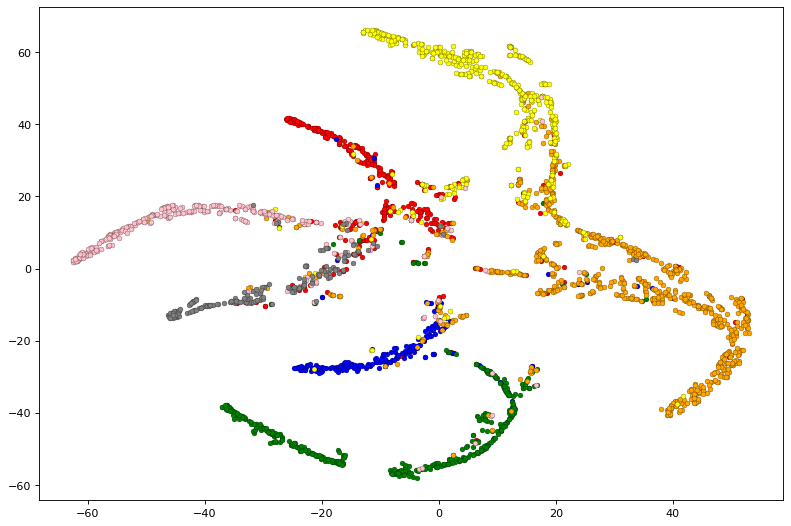

Logistic regression with [20] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.826; Test acc 0.806
The required training time was 0.8 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [30]


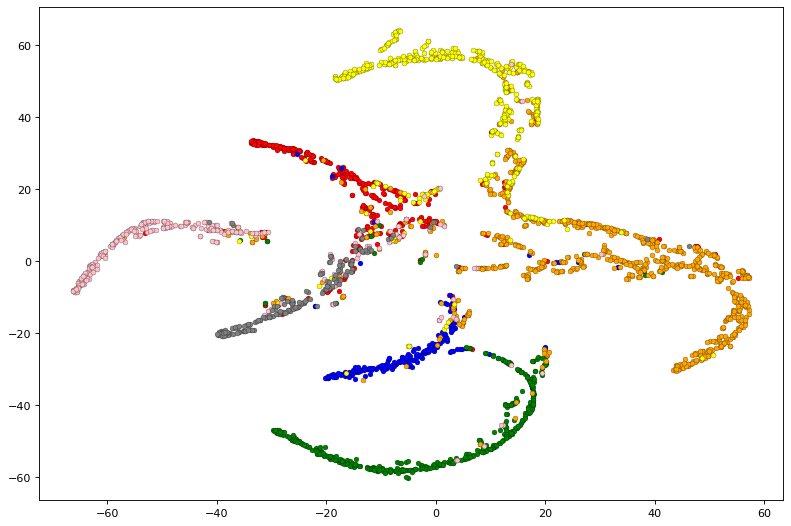

Logistic regression with [30] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.828; Test acc 0.802
The required training time was 1.62 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [1]


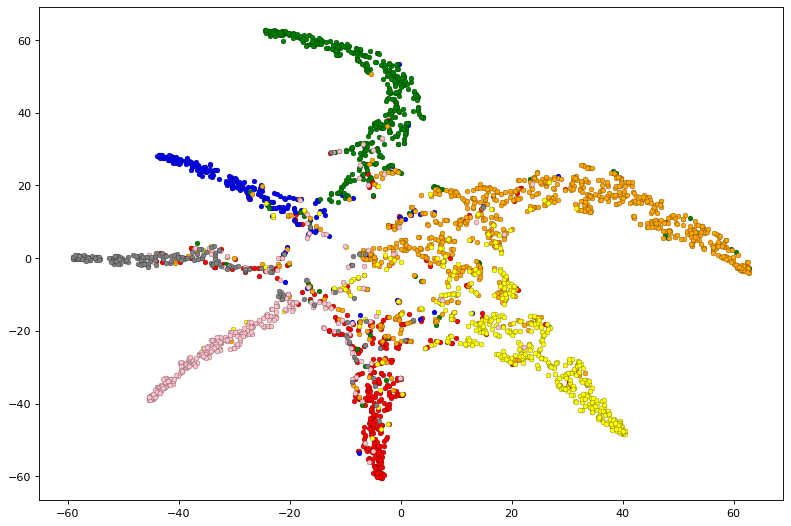

Logistic regression with [1] hops has the following accuracies:
Train acc: 1.0; Val acc 0.766; Test acc 0.786
The required training time was 0.14 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


T-SNE of learned proba with [3]


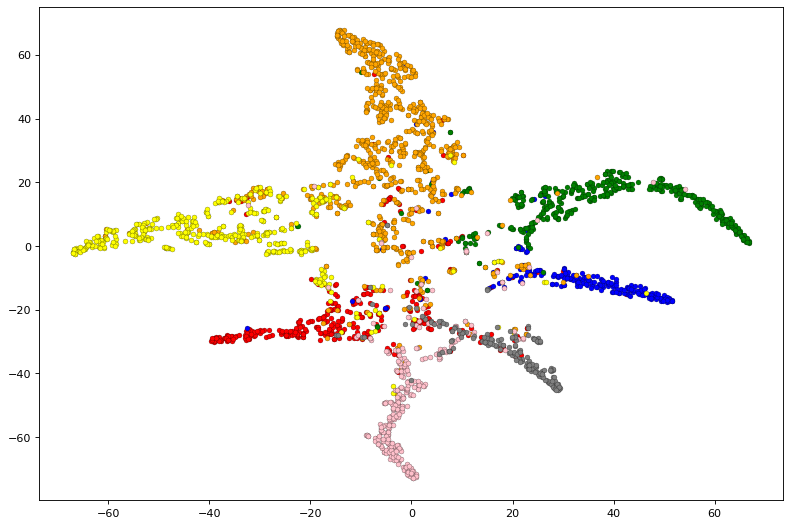

Logistic regression with [3] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.818; Test acc 0.819
The required training time was 0.17 s
T-SNE of learned proba with [4]


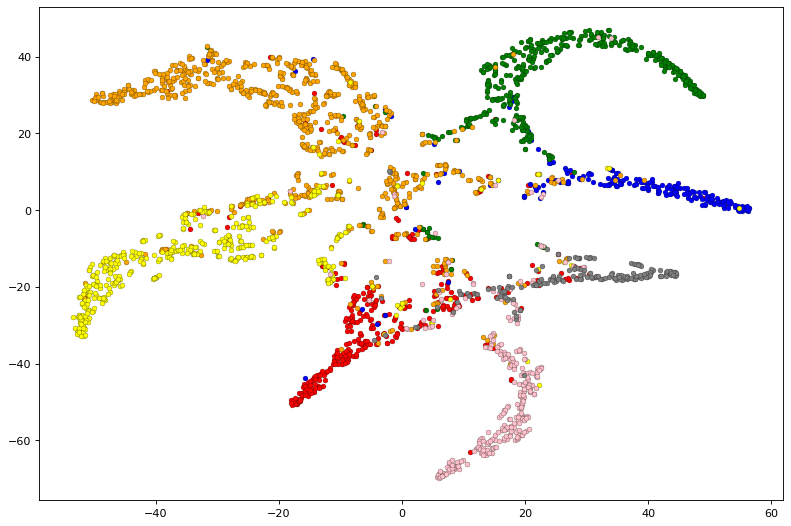

Logistic regression with [4] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.816; Test acc 0.818
The required training time was 0.57 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [6]


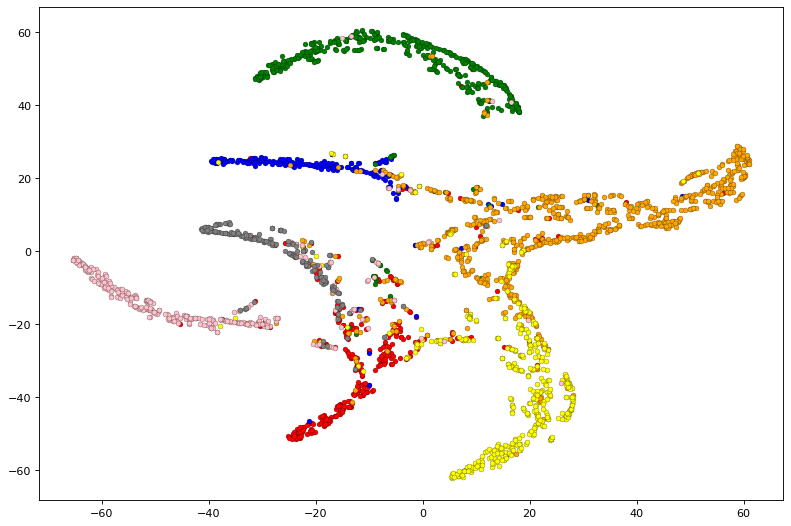

Logistic regression with [6] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.816; Test acc 0.82
The required training time was 0.24 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [7]


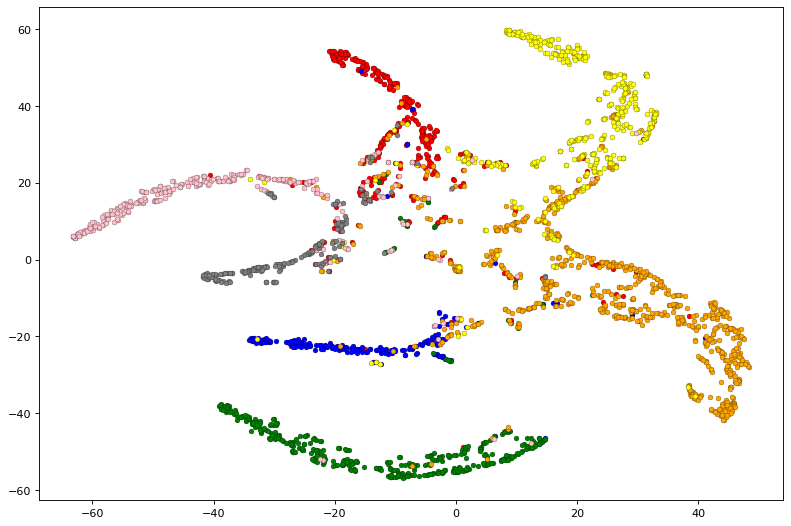

Logistic regression with [7] hops has the following accuracies:
Train acc: 0.9857142857142858; Val acc 0.818; Test acc 0.819
The required training time was 0.26 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [8]


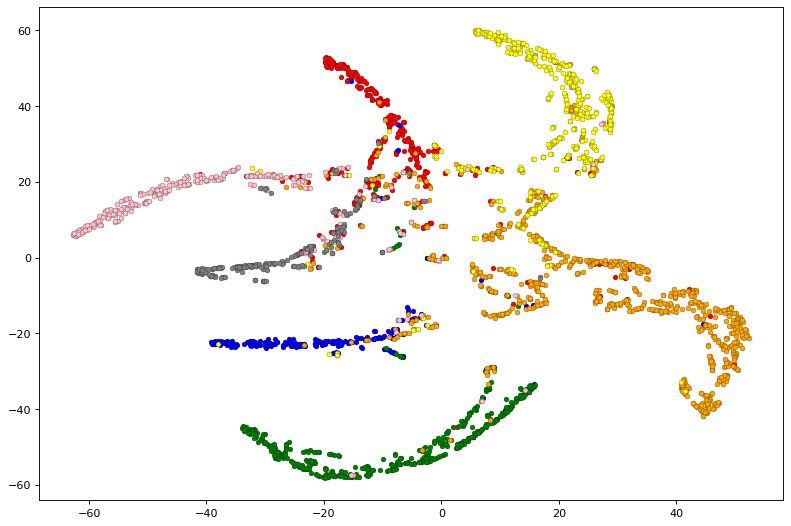

Logistic regression with [8] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.816; Test acc 0.814
The required training time was 0.31 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [9]


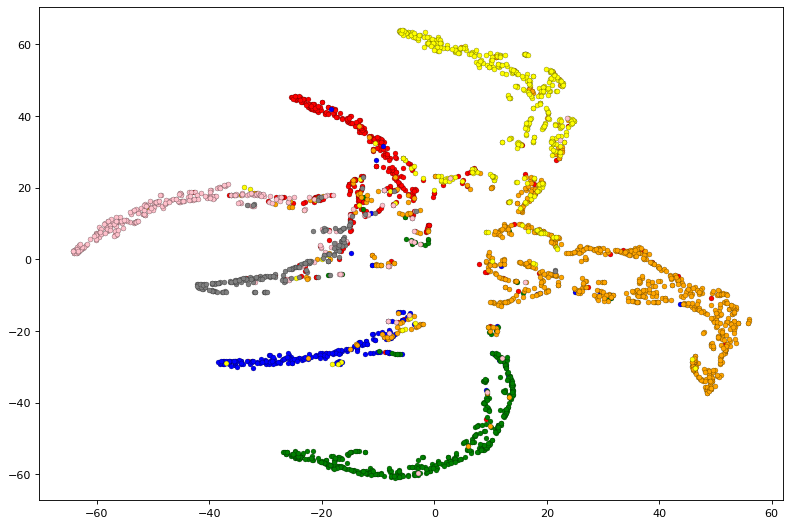

Logistic regression with [9] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.816; Test acc 0.815
The required training time was 0.38 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


T-SNE of learned proba with [40]


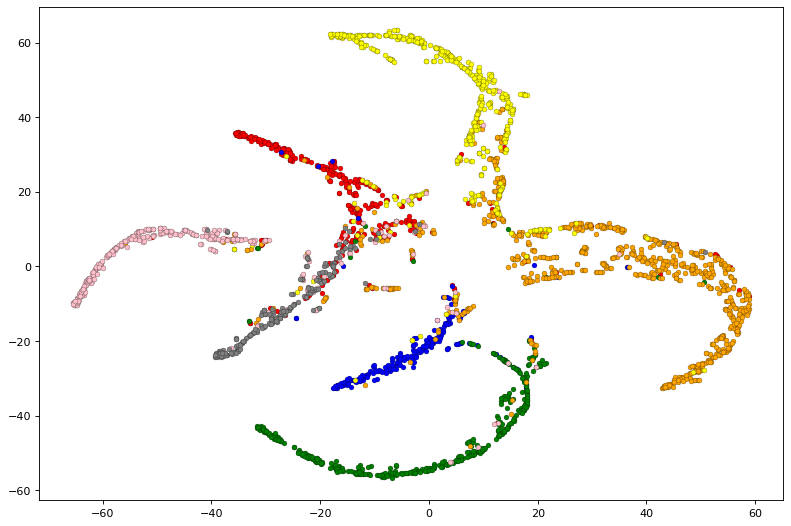

Logistic regression with [40] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.824; Test acc 0.806
The required training time was 2.01 s


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


T-SNE of learned proba with [50]


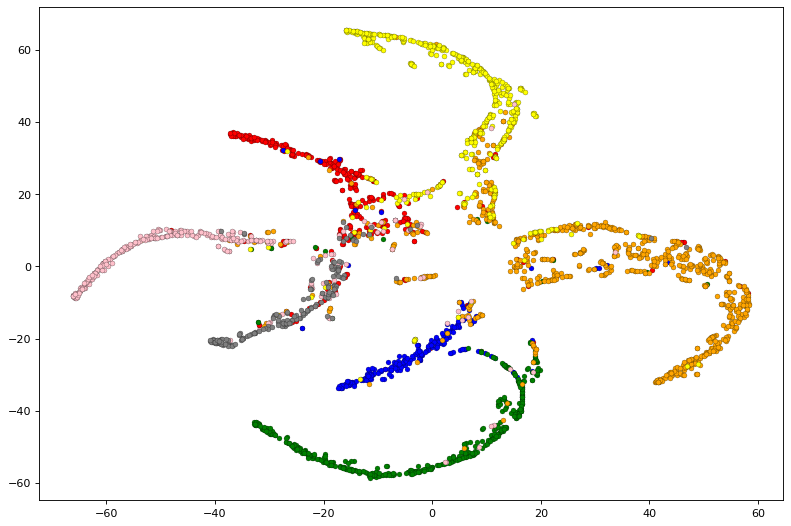

Logistic regression with [50] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.824; Test acc 0.803
The required training time was 2.21 s


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from torch.nn.functional import normalize, softmax
import torch
import numpy as np

def user_function(kwargs):
    return normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p = 2.0, dim = 1) ##updated is a regularization since the neighborhood aggregation is repeated for close neighborhoods

hops_lists = np.expand_dims(evaluated_hops, axis = 1) #[[0], [ 1], [ 2], [ 5], [ 10]]
for hops_list in hops_lists:

    clfs = [
        LogisticRegression(**hops_to_best_params[hops], random_state = 42, solver= "saga") for hops in hops_list
    ]
    framework = Framework([user_function for i in hops_list], 
                         hops_list=hops_list, ## to obtain best for local neighborhood
                         clfs=clfs,
                         gpu_idx=0,
                         handle_nan=0.0,
                        attention_configs=[None for i in hops_list]) 
    # {'inter_layer_normalize': False,
    #                      'use_pseudo_attention':True,
    #                      'cosine_eps':.01,
    #                      'dropout_attn': None}
    new_features = framework.get_features(features, edge_index, torch.ones_like(y).type(torch.bool))
    start = time.time()
    framework.fit(features,
                edge_index,
                y,
                train)
    train_time = time.time()-start
    
    y_pred_val = framework.predict(features,
                    edge_index,
                    val)
    y_pred_test = framework.predict(features,
                    edge_index,
                    test)
    y_pred_train = framework.predict(features,
                    edge_index,
                    train)
    val_score = accuracy_score(y[val], y_pred_val)
    test_score = accuracy_score(y[test], y_pred_test)
    train_score = accuracy_score(y[train], y_pred_train)
    
    proba = framework.predict_proba(features,
                edge_index,
                 torch.ones_like(y).type(torch.bool))
    print(f"T-SNE of learned proba with {str(hops_list)}")
    plot_tsne(proba)
    print(f"Logistic regression with {str(hops_list)} hops has the following accuracies:\nTrain acc: {str(train_score)}; Val acc {str(val_score)}; Test acc {str(test_score)}")
    print(f"The required training time was {str(round(train_time,2))} s")